In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from amftrack.util.video_util import make_video, make_video_tile

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
import sys

sys.path.insert(0, os.getenv("HOME") + "/pycode/MscThesis/")
# sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

import pandas as pd
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    get_current_folders,
    get_folders_by_plate_id,
)


import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    sparse_to_doc,
)
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
directory = directory_project
directory = os.path.join(directory_scratch, "stitch_temp") + "/"

update_plate_info(directory, local=True)
all_folders = get_current_folders(directory, local=True)

analysed:   0%|          | 0/119 [00:00<?, ?it/s]

In [4]:
folders = all_folders.loc[all_folders["Plate"] == "938"]
# folders

In [5]:
folders = folders.loc[folders["/Analysis/skeleton_compressed.mat"] == True]
select = folders

In [17]:
select

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,unique_id,datetime
1,/scratch-shared/amftrack/stitch_temp/20220405_...,938,15,'Carrot','A5','001P100N200C','Y','-',20220325,25,...,True,False,True,True,True,True,"05.04.2022, 22:04:",20220405_2204_Plate15,938_20220325,2022-04-05 22:04:00
2,/scratch-shared/amftrack/stitch_temp/20220330_...,938,15,'Carrot','A5','001P100N200C','Y','-',20220325,25,...,True,False,True,True,True,True,"30.03.2022, 05:14:",20220330_0514_Plate15,938_20220325,2022-03-30 05:14:00
4,/scratch-shared/amftrack/stitch_temp/20220329_...,938,15,'Carrot','A5','001P100N200C','Y','-',20220325,25,...,True,False,True,True,True,True,"29.03.2022, 04:42:",20220329_0442_Plate15,938_20220325,2022-03-29 04:42:00
5,/scratch-shared/amftrack/stitch_temp/20220419_...,938,30,'Carrot','A5','001P100N200C','Y','-',20220325,25,...,True,False,True,True,True,True,"19.04.2022, 16:27:",20220419_1627_Plate30,938_20220325,2022-04-19 16:27:00
6,/scratch-shared/amftrack/stitch_temp/20220406_...,938,15,'Carrot','A5','001P100N200C','Y','-',20220325,25,...,True,False,True,True,True,True,"06.04.2022, 10:04:",20220406_1004_Plate15,938_20220325,2022-04-06 10:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,/scratch-shared/amftrack/stitch_temp/20220330_...,938,15,'Carrot','A5','001P100N200C','Y','-',20220325,25,...,True,False,True,True,True,True,"30.03.2022, 01:14:",20220330_0114_Plate15,938_20220325,2022-03-30 01:14:00
113,/scratch-shared/amftrack/stitch_temp/20220408_...,938,30,'Carrot','A5','001P100N200C','Y','-',20220325,25,...,True,False,True,True,True,True,"08.04.2022, 09:47:",20220408_0947_Plate30,938_20220325,2022-04-08 09:47:00
116,/scratch-shared/amftrack/stitch_temp/20220409_...,938,30,'Carrot','A5','001P100N200C','Y','-',20220325,25,...,True,False,True,True,True,True,"09.04.2022, 05:52:",20220409_0552_Plate30,938_20220325,2022-04-09 05:52:00
117,/scratch-shared/amftrack/stitch_temp/20220411_...,938,30,'Carrot','A5','001P100N200C','Y','-',20220325,25,...,True,False,True,True,True,True,"11.04.2022, 05:52:",20220411_0552_Plate30,938_20220325,2022-04-11 05:52:00


In [6]:
import sys
from amftrack.util.sys import temp_path
import pandas as pd
from pymatreader import read_mat
import cv2
from amftrack.pipeline.functions.image_processing.extract_skel import bowler_hat
import numpy as np
from scipy import sparse
from time import time_ns
from amftrack.util.sys import temp_path
from amftrack.util.dbx import upload
import imageio
import os

In [22]:
path

'/scratch-shared/amftrack/stitch_temp/20220415_0549_Plate30'

In [19]:
select = select.sort_values("datetime")
# select = select.iloc[:10]
imgs = []

kernel = np.ones((5, 5), np.uint8)
itera = 1
resize = (2624, 1312)
texts = list(select["folder"])
fontScale = 3
color = (0, 255, 255)
id_unique = (
    str(int(select["Plate"].iloc[0]))
    + "_"
    + str(int(str(select["CrossDate"].iloc[0]).replace("'", "")))
)
for path in select["total_path"]:
    # print(folder)
    path_snap = path
    skel_info = read_mat(path_snap + "/Analysis/skeleton.mat")
    skel = skel_info["skeleton"]
    im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]
    compressed = sparse.csr_matrix(
        (
            [1] * len(skel.nonzero()[0]),
            (skel.nonzero()[0] // 5, skel.nonzero()[1] // 5),
        ),
        (5405, 10492),
    )
    print(im.shape, skel.shape)
    skel_comp = cv2.dilate(
        compressed.toarray().astype(np.uint8), kernel, iterations=itera
    )
    blackAndWhiteImage3 = cv2.cvtColor(skel_comp, cv2.COLOR_GRAY2BGR)
    blackAndWhiteImage3[skel_comp > 0] = (0, 0, 125)
    blackAndWhiteImage3[skel_comp == 0] = (255, 255, 255)
    blackAndWhiteImage3 = blackAndWhiteImage3[: im.shape[0], : im.shape[1]]
    # bc_rm = bowler_hat(-im, 16, [30])
    bc_rm_f = cv2.cvtColor(
        cv2.normalize(im, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8),
        cv2.COLOR_GRAY2BGR,
    )

    added_image = cv2.addWeighted(blackAndWhiteImage3, 0.3, bc_rm_f, 0.5, 0)
    imgs.append(cv2.resize(added_image, resize))
    im2 = imageio.imread(path_snap + "/Img/Img_r08_c06.tif")
    break

for i, img in enumerate(imgs):
    anchor = img.shape[0] // 10, img.shape[1] // 10
    cv2.putText(
        img=img,
        text=texts[i],
        org=anchor,
        fontFace=cv2.FONT_HERSHEY_TRIPLEX,
        fontScale=fontScale,
        color=color,
        thickness=3,
    )
    break


# time = time_ns()
# save_path_temp = os.path.join(temp_path, f'{time}.mp4')
# imageio.mimsave(save_path_temp, imgs)
# dir_drop = "DATA/PRINCE"
# upload_path = f"/{dir_drop}/{id_unique}/{id_unique}_stitched.mp4"
# upload(save_path_temp, upload_path)

# os.remove(save_path_temp)

(5405, 10492) (27029, 52461)


In [29]:
compressed = sparse.csr_matrix(
    ([1] * len(skel.nonzero()[0]), (skel.nonzero()[0] // 5, skel.nonzero()[1] // 5)),
    (5800, 11000),
)

In [28]:
skel.shape

(29365, 52065)

In [27]:
(skel.nonzero()[0] // 5)

array([   6,    7,    7, ..., 5652, 5652, 5652], dtype=int32)

In [28]:
select = folders
folder_list = list(select["folder"])
folder_list.sort()
skels = []
ims = []
kernel = np.ones((5, 5), np.uint8)
itera = 1
start = 0
kernel = np.ones((5, 5), np.uint8)

# start = choice(range(len(folder_list)))
finish = start + 2
for folder in folder_list[start:finish]:
    # print(folder)
    path_snap = directory + folder
    skel_info = read_mat(path_snap + "/Analysis/skeleton.mat")
    skel = skel_info["skeleton"]
    # skels.append(cv2.dilate(skel.astype(np.uint8), kernel, iterations=itera))
    im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]
    ims.append(im)

In [1]:
for path in select["total_path"]:
    path_snap = path
    skel_info = read_mat(path_snap + "/Analysis/skeleton.mat")
    skel = skel_info["skeleton"]
    # skels.append(cv2.dilate(skel.astype(np.uint8), kernel, iterations=itera))
    im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]
    ims.append(im)

NameError: name 'select' is not defined

In [6]:
from amftrack.pipeline.functions.image_processing.extract_skel import bowler_hat

bckgr_rm = bowler_hat(-im, 16, [15])

In [7]:
compressed = sparse.csr_matrix(
    ([1] * len(skel.nonzero()[0]), (skel.nonzero()[0] // 5, skel.nonzero()[1] // 5)),
    im.shape,
)
skel_comp = cv2.dilate(compressed.toarray().astype(np.uint8), kernel, iterations=itera)

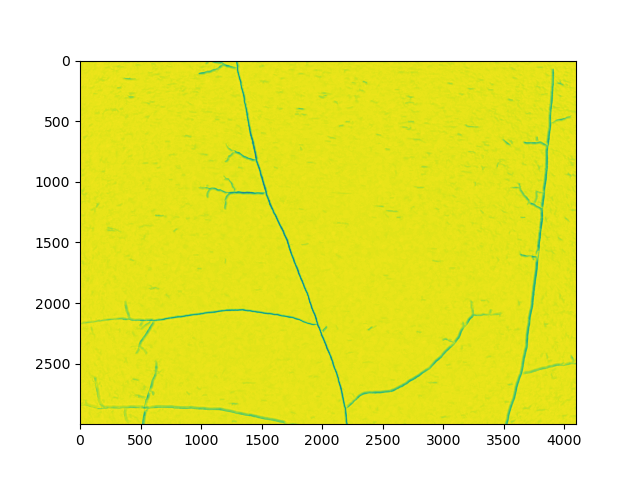

In [27]:
plt.close("all")
fig, ax = plt.subplots()
# transform = -bowler_hat(-im2, 16, [30])
ax.imshow(cv2.normalize(transform, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))
# ax.imshow(cv2.dilate(compressed.toarray().astype(np.uint8), kernel, iterations=itera),alpha = 0.5)
# ax.spy(compressed,marker = '-', markersize=1,alpha = 0.5)

array([[243, 243, 243, ..., 236, 236, 231],
       [245, 243, 243, ..., 236, 236, 231],
       [243, 243, 243, ..., 240, 238, 231],
       ...,
       [247, 245, 250, ..., 240, 243, 240],
       [243, 247, 243, ..., 245, 240, 240],
       [252, 243, 247, ..., 243, 240, 243]], dtype=uint8)

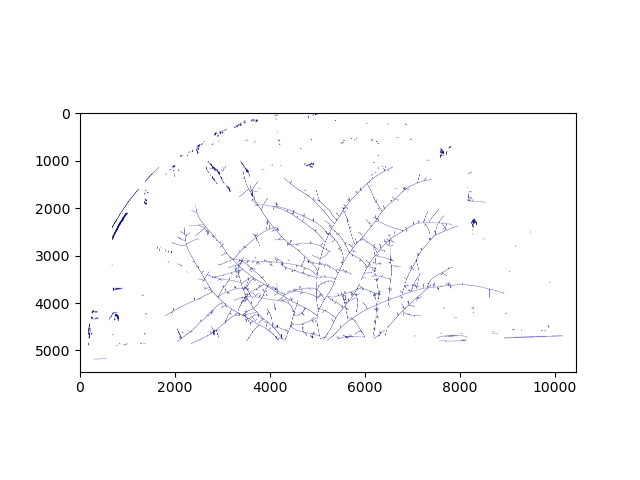

In [22]:
fig, ax = plt.subplots()
# ax.imshow(bckgr_rm)
blackAndWhiteImage3 = cv2.cvtColor(skel_comp, cv2.COLOR_GRAY2BGR)
blackAndWhiteImage3[skel_comp > 0] = (0, 0, 125)
blackAndWhiteImage3[skel_comp == 0] = (255, 255, 255)

ax.imshow(blackAndWhiteImage3)
# ax.spy(compressed,marker = '-', markersize=1,alpha = 0.5)

In [15]:
bckgr_rm_f = cv2.cvtColor(
    cv2.normalize(bckgr_rm, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8),
    cv2.COLOR_GRAY2BGR,
)

In [16]:
np.max(bckgr_rm_f)

255

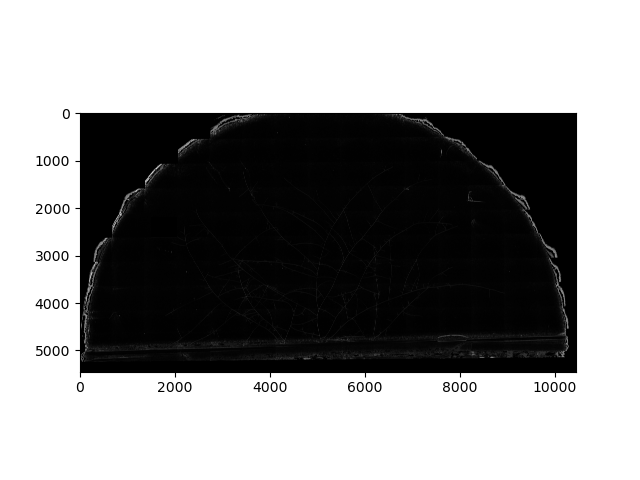

In [17]:
fig, ax = plt.subplots()
ax.imshow(bckgr_rm_f)

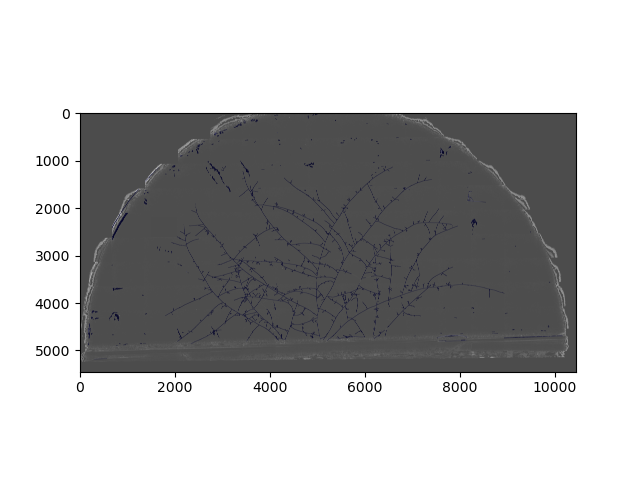

In [25]:
added_image = cv2.addWeighted(blackAndWhiteImage3, 0.3, bckgr_rm_f, 0.5, 0)
fig, ax = plt.subplots()
ax.imshow(added_image)

In [43]:
skel_comp.shape, bckgr_rm.astype(np.uint8).shape

((5446, 10453), (5446, 10453))

In [41]:
compressed = sparse.csr_matrix(
    ([1] * len(skel.nonzero()[0]), (skel.nonzero()[0] // 5, skel.nonzero()[1] // 5)),
    im.shape,
)

In [5]:
from skimage import data, restoration, util

In [ ]:
compress = 3
shape = im.shape[1] // compress, im.shape[0] // compress
img = cv2.resize(im2, shape)

In [ ]:
background = restoration.rolling_ball(im)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(im - background)

In [36]:
im_new = ims[0] + (ims[0] <= 30) * 120

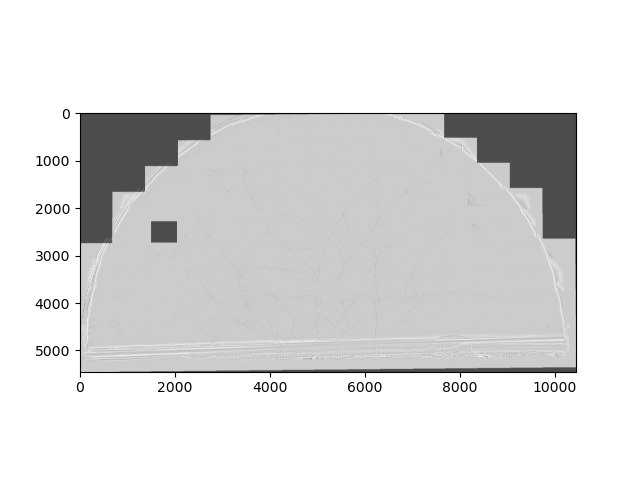

In [57]:
fig, ax = plt.subplots()

shape = im.shape[1], im.shape[0]
ax.imshow(cv2.resize(im2, shape), cmap="gray")
ax.imshow(-im_new, cmap="gray", alpha=0.5)

In [65]:
# !pip install opencv-rolling-ball
from cv2_rolling_ball import subtract_background_rolling_ball

img = cv2.resize(im, (im.shape[1] // 3, im.shape[0] // 3))
img, background = subtract_background_rolling_ball(
    img, 1, light_background=True, use_paraboloid=True, do_presmooth=True
)

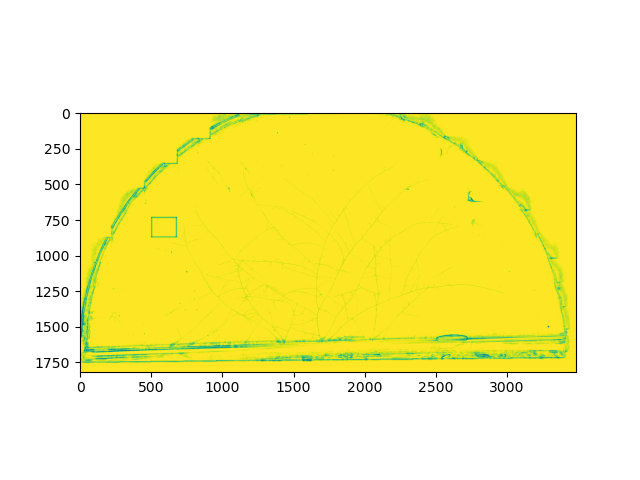

In [66]:
fig, ax = plt.subplots()
ax.imshow(img)

In [50]:
im2 = imageio.imread(path_snap + "/StitchedImage.tif")

(array([5.2769000e+04, 8.7190000e+04, 1.1242000e+05, 2.4335200e+05,
        1.6761700e+05, 2.0533600e+05, 3.4019500e+05, 3.5968000e+05,
        4.6023100e+05, 6.0379300e+05, 1.4814210e+06, 3.7077785e+07,
        1.4193073e+07, 6.5992500e+05, 2.8711100e+05, 2.4629800e+05,
        7.0021000e+04, 8.3382000e+04, 3.4127000e+04, 4.2511000e+04,
        1.3985000e+04, 1.6395000e+04, 1.2168000e+04, 1.2632000e+04,
        1.0864000e+04, 1.0818000e+04, 6.9000000e+03, 2.7413000e+04,
        1.2040000e+03, 9.7600000e+02]),
 array([ 31.        ,  38.46666667,  45.93333333,  53.4       ,
         60.86666667,  68.33333333,  75.8       ,  83.26666667,
         90.73333333,  98.2       , 105.66666667, 113.13333333,
        120.6       , 128.06666667, 135.53333333, 143.        ,
        150.46666667, 157.93333333, 165.4       , 172.86666667,
        180.33333333, 187.8       , 195.26666667, 202.73333333,
        210.2       , 217.66666667, 225.13333333, 232.6       ,
        240.06666667, 247.53333333, 

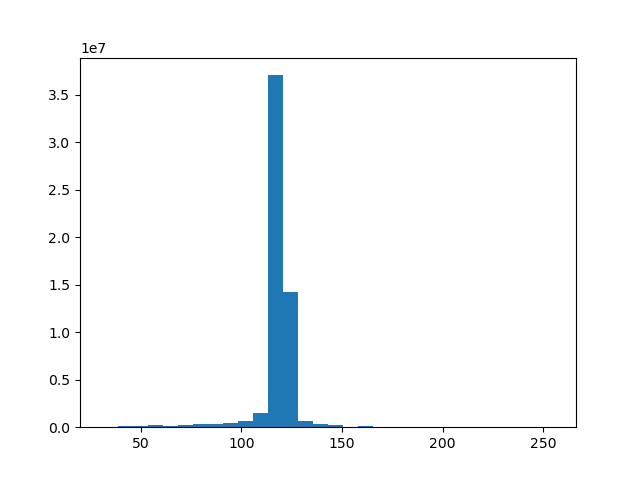

In [37]:
fig, ax = plt.subplots()
ax.hist(np.ndarray.flatten(im_new), 30)

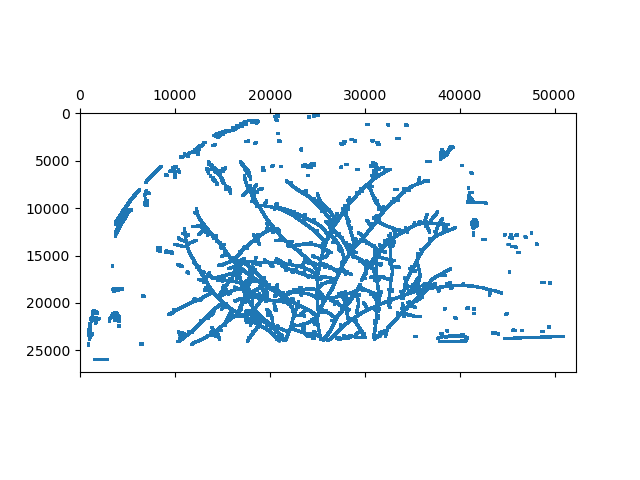

In [17]:
fig, ax = plt.subplots()
ax.spy(skel, markersize=1)

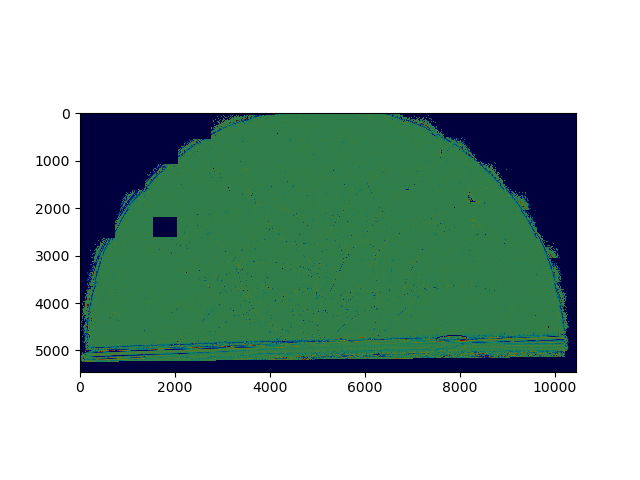

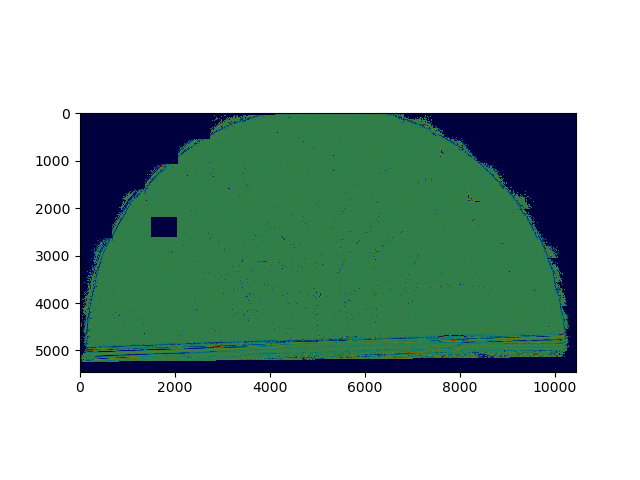

In [7]:
plt.close("all")
start = 0
finish = start + 2
for i in range(start, finish):
    plot_t_tp1([], [], None, None, ims[i], 0 * ims[i])

In [5]:
tileconfig = pd.read_table(
    "TileConfiguration.txt.registered",
    sep=";",
    skiprows=4,
    header=None,
    converters={2: ast.literal_eval},
    skipinitialspace=True,
)

In [20]:
tileconfig

,0,1,2
0,/scratch/shared/AMF914/Fiji.app/20201123_1253_...,NaN,"(0.0, 0.0)"
1,/scratch/shared/AMF914/Fiji.app/20201123_1253_...,NaN,"(3478.701, 54.14514)"
2,/scratch/shared/AMF914/Fiji.app/20201123_1253_...,NaN,"(6972.0596, 109.02173)"
3,/scratch/shared/AMF914/Fiji.app/20201123_1253_...,NaN,"(10469.834, 165.35864)"
4,/scratch/shared/AMF914/Fiji.app/20201123_1253_...,NaN,"(13977.264, 221.36694)"
...,...,...,...
123,/scratch/shared/AMF914/Fiji.app/20201123_1253_...,NaN,"(20498.27, 23374.621)"
124,/scratch/shared/AMF914/Fiji.app/20201123_1253_...,NaN,"(23977.553, 23423.21)"
125,/scratch/shared/AMF914/Fiji.app/20201123_1253_...,NaN,"(27468.75, 23479.809)"
126,/scratch/shared/AMF914/Fiji.app/20201123_1253_...,NaN,"(30981.217, 23541.879)"


In [11]:
folder = all_folders.iloc[0]["total_path"]

In [8]:
folder

'/projects/0/einf914/data/20220405_1343_Plate05'

In [38]:
xs = [c[0] for c in tileconfig[2]]
ys = [c[1] for c in tileconfig[2]]
compress = 25
dim = (int(np.max(ys) - np.min(ys)) + 5500, int(np.max(xs) - np.min(xs)) + 5500)
dim = (dim[0] // compress, dim[1] // compress)
mask = np.zeros(dim, dtype=np.uint8)

for index, name in enumerate(tileconfig[0]):
    imname = "Img/" + name.split("/")[-1]
    path = os.path.join(folder, imname)
    im = imageio.imread(path)
    shape = im.shape
    shape = shape[0] // compress, shape[1] // compress
    im_cropped = im
    # im_blurred = cv2.blur(im_cropped, (400, 400))
    # im_back_rem = (
    #     (im_cropped)
    #     / ((im_blurred == 0) * np.ones(im_blurred.shape) + im_blurred)
    #     * 120
    # )
    im_back_rem = im
    im_back_rem = cv2.resize(im_back_rem, (shape[1], shape[0]))
    boundaries = int(tileconfig[2][index][0] - np.min(xs)), int(
        tileconfig[2][index][1] - np.min(ys)
    )
    boundaries = boundaries[0] // compress, boundaries[1] // compress
    mask[
        boundaries[1] : boundaries[1] + shape[0],
        boundaries[0] : boundaries[0] + shape[1],
    ] = im_back_rem

In [39]:
imageio.imsave("test.tif", mask)

In [37]:
from amftrack.util.sys import path_code

i = 0
folder = all_folders.iloc[i]["total_path"]
path_tile = (
    f"{path_code}pipeline/scripts/stitching_loops/TileConfiguration.txt.registered"
)
tileconfig = pd.read_table(
    path_tile,
    sep=";",
    skiprows=4,
    header=None,
    converters={2: ast.literal_eval},
    skipinitialspace=True,
)
xs = [c[0] for c in tileconfig[2]]
ys = [c[1] for c in tileconfig[2]]
dim = (int(np.max(ys) - np.min(ys)) + 5500, int(np.max(xs) - np.min(xs)) + 5500)
dim = (dim[0] // compress, dim[1] // compress)
mask = np.zeros(dim, dtype=np.uint8)

for index, name in enumerate(tileconfig[0]):
    imname = "Img/" + name.split("/")[-1]
    path = os.path.join(folder, imname)
    im = imageio.imread(path)
    shape = im.shape
    shape = shape[0] // compress, shape[1] // compress
    im_cropped = im
    im_back_rem = im
    im_back_rem = cv2.resize(im_back_rem, (shape[1], shape[0]))
    boundaries = int(tileconfig[2][index][0] - np.min(xs)), int(
        tileconfig[2][index][1] - np.min(ys)
    )
    boundaries = boundaries[0] // compress, boundaries[1] // compress
    mask[
        boundaries[1] : boundaries[1] + shape[0],
        boundaries[0] : boundaries[0] + shape[1],
    ] = im_back_rem

imageio.imsave(os.path.join(folder, "StitchedImage.tif"), mask)

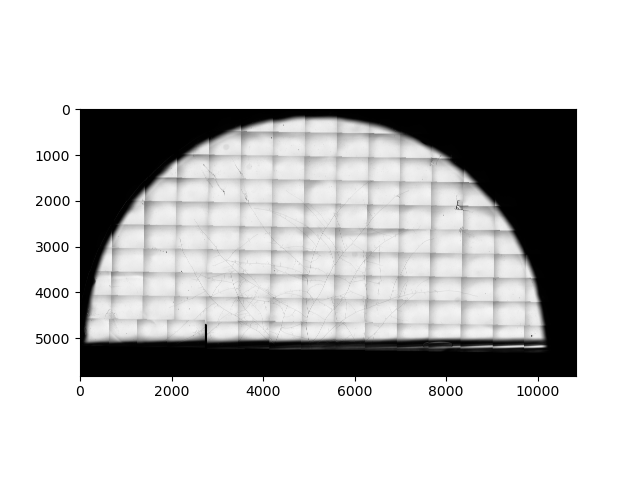

In [30]:
fig, ax = plt.subplots()
ax.imshow(mask, cmap="gray")

In [10]:
all_folders = all_folders.sort_values("datetime")
paths = list(all_folders["total_path"])
paths = [os.path.join(path, "StitchedImage.tif") for path in paths]
texts = list(all_folders["folder"])
id_unique = (
    str(int(all_folders["Plate"].iloc[0]))
    + "_"
    + str(int(str(all_folders["CrossDate"].iloc[0]).replace("'", "")))
)
dir_drop = "DATA/PRINCE"
upload_path = f"/{dir_drop}/{id_unique}/test.mp4"

In [8]:
save_path

'/DATA/PRINCE/931_20220402/test.mp4'

In [16]:
resize = (2624, 1312)
save_path = "test.mp4"
make_video(paths, texts, resize, save_path=None, upload_path=upload_path, fontScale=3)

2022-06-09 16:51:46,373-[INFO]- dropbox:388 -> Refreshing access token.
2022-06-09 16:51:46,599-[INFO]- dropbox:477 -> Request to files/upload


[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 

In [ ]:
all_folders = all_folders.sort_values("datetime")
paths = list(all_folders["total_path"])
paths = [os.path.join(path, "Img", "Img_r08_c06.tif") for path in paths]
texts = list(all_folders["folder"])
resize = (2048, 1504)
save_path = "test_2.mp4"
make_video(paths, texts, resize, save_path=save_path, upload=False, fontScale=3)

In [8]:
all_folders = all_folders.sort_values("datetime")
paths = list(all_folders["total_path"])[:50]
paths_list = [
    [
        os.path.join(path, "Img", "Img_r08_c06.tif"),
        os.path.join(path, "Img", "Img_r07_c06.tif"),
    ]
    for path in paths
]
texts = [(folder, "") for folder in list(all_folders["folder"])]
resize = (2048, 1504)
save_path = "test_3.mp4"
make_video_tile(
    paths_list, texts, resize, save_path=save_path, upload=False, fontScale=3
)

[array([[[102, 102, 102],
         [105, 105, 105],
         [107, 107, 107],
         ...,
         [122, 122, 122],
         [121, 121, 121],
         [121, 121, 121]],
 
        [[107, 107, 107],
         [108, 108, 108],
         [110, 110, 110],
         ...,
         [120, 120, 120],
         [120, 120, 120],
         [120, 120, 120]],
 
        [[108, 108, 108],
         [105, 105, 105],
         [110, 110, 110],
         ...,
         [120, 120, 120],
         [121, 121, 121],
         [119, 119, 119]],
 
        ...,
 
        [[114, 114, 114],
         [111, 111, 111],
         [111, 111, 111],
         ...,
         [153, 153, 153],
         [152, 152, 152],
         [153, 153, 153]],
 
        [[113, 113, 113],
         [111, 111, 111],
         [111, 111, 111],
         ...,
         [153, 153, 153],
         [154, 154, 154],
         [155, 155, 155]],
 
        [[108, 108, 108],
         [110, 110, 110],
         [111, 111, 111],
         ...,
         [153, 153, 153],
  

In [6]:
imgs = [cv2.imread(path, cv2.IMREAD_COLOR) for path in paths]
imgconc = cv2.vconcat([imgs[0], imgs[1]])

In [13]:
imgconc = cv2.vconcat([imgs[0], imgs[1]])

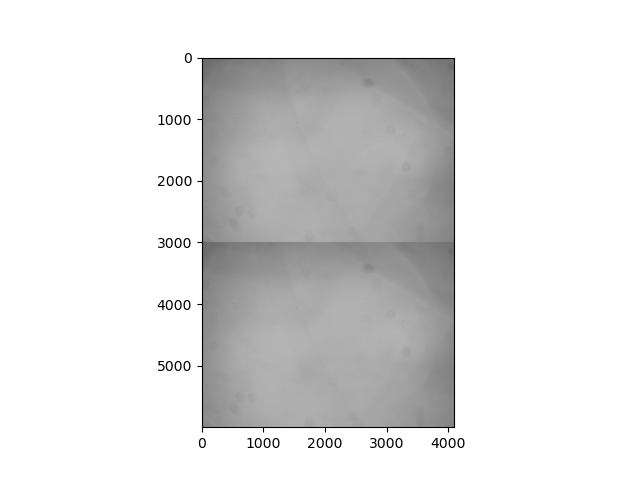

In [14]:
fig, ax = plt.subplots()
ax.imshow(imgconc)

In [ ]:
all_folders = all_folders.sort_values("datetime")
paths = list(all_folders["total_path"])
paths = [os.path.join(path, Img, "StitchedImage.tif") for path in paths]
texts = list(all_folders["folder"])

In [95]:
imgs = [cv2.imread(path, cv2.IMREAD_COLOR) for path in paths]
# slices=[(slice(0,1309),slice(0,2620)) for path in paths]
imgs = [cv2.resize(img, (2624, 1312)) for img in imgs]
# imgs = [imgs[i][slice_i] for i,slice_i in enumerate(slices)]
for i, img in enumerate(imgs):
    anchor = img.shape[0] // 10, img.shape[1] // 10
    cv2.putText(
        img=img,
        text=texts[i],
        org=anchor,
        fontFace=cv2.FONT_HERSHEY_TRIPLEX,
        fontScale=4,
        color=(0, 255, 255),
        thickness=3,
    )

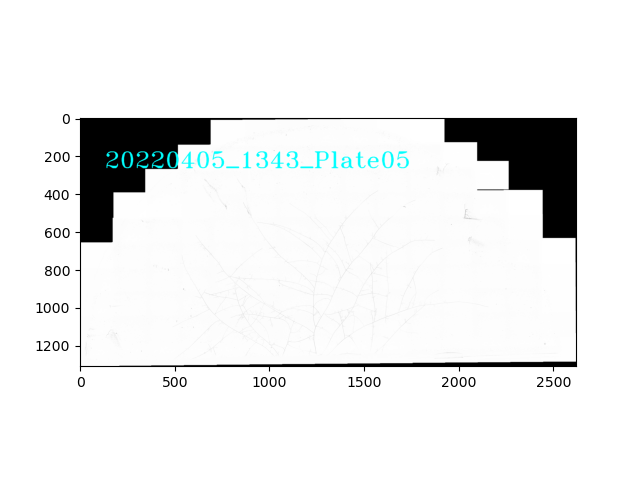

In [91]:
fig, ax = plt.subplots()
ax.imshow(imgs[0])

In [96]:
imageio.mimsave("test.mp4", imgs)

2022-06-09 14:50:57,597-[WARNING]- imageio_ffmpeg:432 -> IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2620, 1309) to (2624, 1312) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


[swscaler @ 0x7221640] Warning: data is not aligned! This can lead to a speed loss


In [72]:
len(paths)

243

In [55]:
help(imageio.mimsave)

Help on function mimwrite in module imageio.core.functions:

mimwrite(uri, ims, format=None, **kwargs)
    mimwrite(uri, ims, format=None, **kwargs)
    
    Write multiple images to the specified file.
    
    Parameters
    ----------
    uri : {str, pathlib.Path, file}
        The resource to write the images to, e.g. a filename, pathlib.Path
        or file object, see the docs for more info.
    ims : sequence of numpy arrays
        The image data. Each array must be NxM, NxMx3 or NxMx4.
    format : str
        The format to use to read the file. By default imageio selects
        the appropriate for you based on the filename and its contents.
    kwargs : ...
        Further keyword arguments are passed to the writer. See :func:`.help`
        to see what arguments are available for a particular format.

